In [31]:
import os

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as gridspec
import dill

import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
sparse_mice = stx.ymaze_sess_deets.sparse_mice

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
from STX3KO_analyses.path_dicts.path_dict_esay import path_dictionary as path_dict
pkl_base_dir = path_dict['pkl_root']


In [33]:
# ella's custom functions

# modify timeseries for MUXED data (add Nan frames between values to align with lick/speed)
def align_mux(sess):
    for key in list (sess.timeseries.keys()):
        data=sess.timeseries[key]

        if f'channel_0' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,::2] = data # place chan0 values at even index

        elif f'channel_1' in key:
            new_data = np.empty((data.shape[0], data.shape[1] *2))
            new_data[:] = np.nan
            new_data[:,1::2] = data # place chan1 values at odd index

        else:
            continue 

        sess.timeseries[key] = new_data
        
# remove Nan values when saving sess file
def reverse_mux_alignment(self, df_key = "channel_0_F_dff"):
    df = sess.timeseries[df_key]

    unmux = df[:, ~np.isnan(df).all(axis=0)]

    self.timeseries[df_key] = unmux

# mask for plotting place cells + removing interneurons (corr with speed)
def place_cell_only_mask(sess):
    chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
    chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
    chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
    chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']
    
    chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
    chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right


    int_mask1 = u.is_putative_interneuron(sess, ts_key='channel_1_F_dff', method='speed',
                            prct=10, r_thresh=0.3)

    int_mask0 = u.is_putative_interneuron(sess, ts_key='channel_0_F_dff', method='speed',
                                prct=10, r_thresh=0.3)
    
    chan1_mask = np.logical_and(chan1_mask, int_mask1)
    chan0_mask = np.logical_and(chan0_mask, int_mask0)

    return chan1_mask, chan0_mask

# function to plot heatmaps of place cell activity 
def plot_cells(trial_mat, cell_inds=None, n_cols=20):
    '''

    :param ca1:
    :param cell_inds: indices of cells to plot
    :param save_figs:
    :return:
    '''

    if cell_inds is None:
        cell_inds = np.arange(trial_mat.shape[-1])

    n_rows = int(np.ceil(cell_inds.shape[0] / n_cols))
    fig = plt.figure(figsize=[30, 3 * n_rows])
    gs = gridspec(n_rows, n_cols)
    '''
    ES changes: 
    - indexing for pc only indexing error
    '''
    
    # for cell in cell_inds:
    for i, cell in enumerate(cell_inds):
        # col = cell % n_cols
        col = i % n_cols
        # row = int(cell / n_cols)
        row = i //n_cols
        ax = fig.add_subplot(gs[row, col])
        h = ax.imshow(trial_mat[:, :, cell], cmap="magma")

        if col == 0:
            ax.set_xlabel('pos')
            ax.set_ylabel('trial #')
            if row==0:
                plt.colorbar(h,ax=ax)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    fig.subplots_adjust(hspace=.3)
    return fig

In [34]:
sparse_sessions.keys()

dict_keys(['SparseKO_05', 'SparseKO_02', 'SparseKO_03'])

In [96]:
mouse = 'SparseKO_05'
d = sparse_sessions[mouse][5]
print(d)

{'date': '21_11_2024', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 16, 'novel_arm': -1, 'exp_day': 6}


In [97]:
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
print(scene)
# basedir = f'/mnt/BigDisk/2P_scratch/{mouse}/{date}/{scene}'
# basedir = f'C://Users/esay/data/Stx3/{mouse}/{date}/{scene}'
basedir = f'Z://giocomo/esay/Stx3/2pData/{mouse}/{date}/{scene}'

stem =  os.path.join(basedir, f'{scene}_{session:03}_{scan:03}')

d.update({'mouse': mouse ,
          'scan_file':stem + '.sbx',
          'scanheader_file': stem + '.mat',
          'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",mouse,date,"%s_%d.sqlite" %(scene,session)),
          'scan_number': scan,
          'prompt_for_keys': False,
          'VR_only': False,
          'scanner': "NLW",
          'n_channels':2,
             })

YMaze_LNovel


In [98]:
d

{'date': '21_11_2024',
 'scene': 'YMaze_LNovel',
 'session': 1,
 'scan': 16,
 'novel_arm': -1,
 'exp_day': 6,
 'mouse': 'SparseKO_05',
 'scan_file': 'Z://giocomo/esay/Stx3/2pData/SparseKO_05/21_11_2024/YMaze_LNovel\\YMaze_LNovel_001_016.sbx',
 'scanheader_file': 'Z://giocomo/esay/Stx3/2pData/SparseKO_05/21_11_2024/YMaze_LNovel\\YMaze_LNovel_001_016.mat',
 'vr_filename': 'Z://giocomo/esay/Stx3/VRData\\SparseKO_05\\21_11_2024\\YMaze_LNovel_1.sqlite',
 'scan_number': 16,
 'prompt_for_keys': False,
 'VR_only': False,
 'scanner': 'NLW',
 'n_channels': 2}

In [99]:
sess = stx.session.YMazeSession(**d)
sess.load_scan_info(sbx_version=3)
sess.align_VR_to_2P()
sess.load_suite2p_data(which_ts=('F', 'Fneu','spks'), mux = True)
sess.get_trial_info()


Fixing teleports
frame rate 31.25
(141055,) ttl times,(60592,) ca2+ frame times
last time: VR 1938.96775, ca2+ 1938.912
frame rate 31.25
(141055,) ttl times,(60592,) ca2+ frame times
last time: VR 1938.96775, ca2+ 1938.912
(30296, 17) (30296, 17)
['Z://giocomo/esay/Stx3/2pData/SparseKO_05/21_11_2024/YMaze_LNovel\\YMaze_LNovel_001_016\\suite2p', 'Z://giocomo/esay/Stx3/2pData/SparseKO_05/21_11_2024/YMaze_LNovel\\YMaze_LNovel_001_016\\chan2/suite2p']


In [100]:
sess.timeseries['channel_1_F'].shape[1]

30296

In [101]:
sess.vr_data.shape[0]

60592

In [102]:
# add nan values in even and odd spaces for matching lengths
align_mux(sess)

In [103]:
# mask nan values
chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1
chan0_nanmask, chan1_nanmask

(array([ True, False,  True, ..., False,  True, False]),
 array([False,  True, False, ...,  True, False,  True]))

In [104]:
sess.neuropil_corrected_dff_ES(Fkey = 'channel_0_F', 
                            Fneukey='channel_0_Fneu', 
                            tau=sess.s2p_ops['channel_0']['tau'],
                               chan_mask = chan0_nanmask,
                            spks_key='channel_0_spks')
sess.neuropil_corrected_dff_ES(Fkey = 'channel_1_F', 
                            Fneukey='channel_1_Fneu', 
                            tau=sess.s2p_ops['channel_1']['tau'],
                               chan_mask = chan1_nanmask,
                            spks_key='channel_1_spks')


365 16728
[  366   368   370 ... 16722 16724 16726]
18606 60591
[18606 18608 18610 ... 60586 60588 60590]


c:\users\esay\repos\twoputils\TwoPUtils\spatial_analyses.py:73: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


365 16728
[  365   367   369 ... 16723 16725 16727]
18606 60591
[18607 18609 18611 ... 60585 60587 60589]


In [105]:
sess.add_timeseries(licks=sess.vr_data['lick']._values)
sess.add_pos_binned_trial_matrix('licks')
speed = sess.vr_data['dz']._values*sess.scan_info['frame_rate']
sess.add_timeseries(speed=sess.vr_data['dz']._values)
sess.add_pos_binned_trial_matrix('speed')

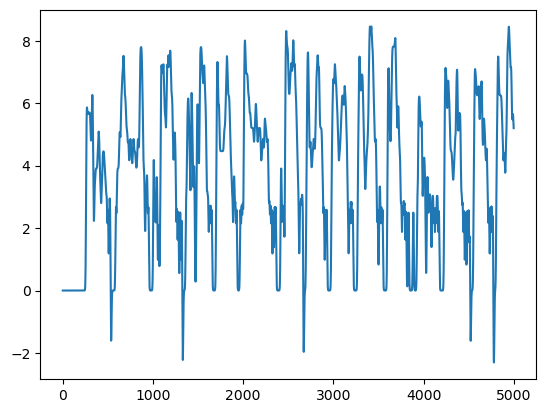

In [106]:
fig,ax = plt.subplots()
ax.plot(speed[:5000])


spks = np.copy(sess.timeseries['channel_0_F_dff'])
sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
spks[:,speed<2]=np.nan
sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')


spks = np.copy(sess.timeseries['channel_1_F_dff'])
spks[:,speed<2]=np.nan
sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')


In [107]:
sess.trial_matrices.keys()

dict_keys(['channel_0_F_dff', 'bin_edges', 'bin_centers', 'channel_0_spks', 'channel_1_F_dff', 'channel_1_spks', 'licks', 'speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt'])

In [108]:
sess.timeseries.keys()

dict_keys(['channel_0_F', 'channel_0_Fneu', 'channel_0_spks', 'channel_1_F', 'channel_1_Fneu', 'channel_1_spks', 'channel_0_F_dff', 'channel_1_F_dff', 'licks', 'speed', 'channel_0_F_dff_speed_filt', 'channel_1_F_dff_speed_filt'])

In [109]:
sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100)
sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100)

perm 0
perm 0
perm 0
perm 0


In [110]:
# create mask for place cells only 

chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']

chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

In [111]:
# mask for interneurons
int_mask1 = u.is_putative_interneuron(sess, ts_key='channel_1_F_dff', method='speed',
                            prct=10, r_thresh=0.3)

int_mask0 = u.is_putative_interneuron(sess, ts_key='channel_0_F_dff', method='speed',
                            prct=10, r_thresh=0.3)

chan1_mask = np.logical_and(chan1_mask, int_mask1)
chan0_mask = np.logical_and(chan0_mask, int_mask0)


In [112]:
# add nan values back into trials
reverse_mux_alignment(sess, df_key = 'channel_0_F_dff')
reverse_mux_alignment(sess, df_key = 'channel_1_F_dff')

In [121]:
sess.timeseries['channel_0_F_dff'].shape

(156, 29174)

In [122]:
output_path = os.path.join("C://Users/esay/data/Stx3/YMazeSessPkls/")
tpu.sess.save_session(sess,output_path)

In [29]:
# load 
pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)

In [49]:
def plot_cells(trial_mat, cell_inds=None, n_cols=20):
    '''

    :param ca1:
    :param cell_inds: indices of cells to plot
    :param save_figs:
    :return:
    '''

    if cell_inds is None:
        cell_inds = np.arange(trial_mat.shape[-1])

    n_rows = int(np.ceil(cell_inds.shape[0] / n_cols))
    fig = plt.figure(figsize=[30, 3 * n_rows])
    gs = gridspec(n_rows, n_cols)
    '''
    ES changes: 
    - indexing for pc only indexing error
    '''
    
    # for cell in cell_inds:
    for i, cell in enumerate(cell_inds):
        # col = cell % n_cols
        col = i % n_cols
        # row = int(cell / n_cols)
        row = i //n_cols
        ax = fig.add_subplot(gs[row, col])
        h = ax.imshow(trial_mat[:, :, cell], cmap="magma")

        if col == 0:
            ax.set_xlabel('pos')
            ax.set_ylabel('trial #')
            if row==0:
                plt.colorbar(h,ax=ax)
        else:
            ax.set_xticks([])
            ax.set_yticks([])
    fig.subplots_adjust(hspace=.3)
    return fig

In [123]:
sess.trial_info['LR']

array([-1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,
       -1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
        1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
       -1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,
       -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,
        1.,  1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,
       -1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.])

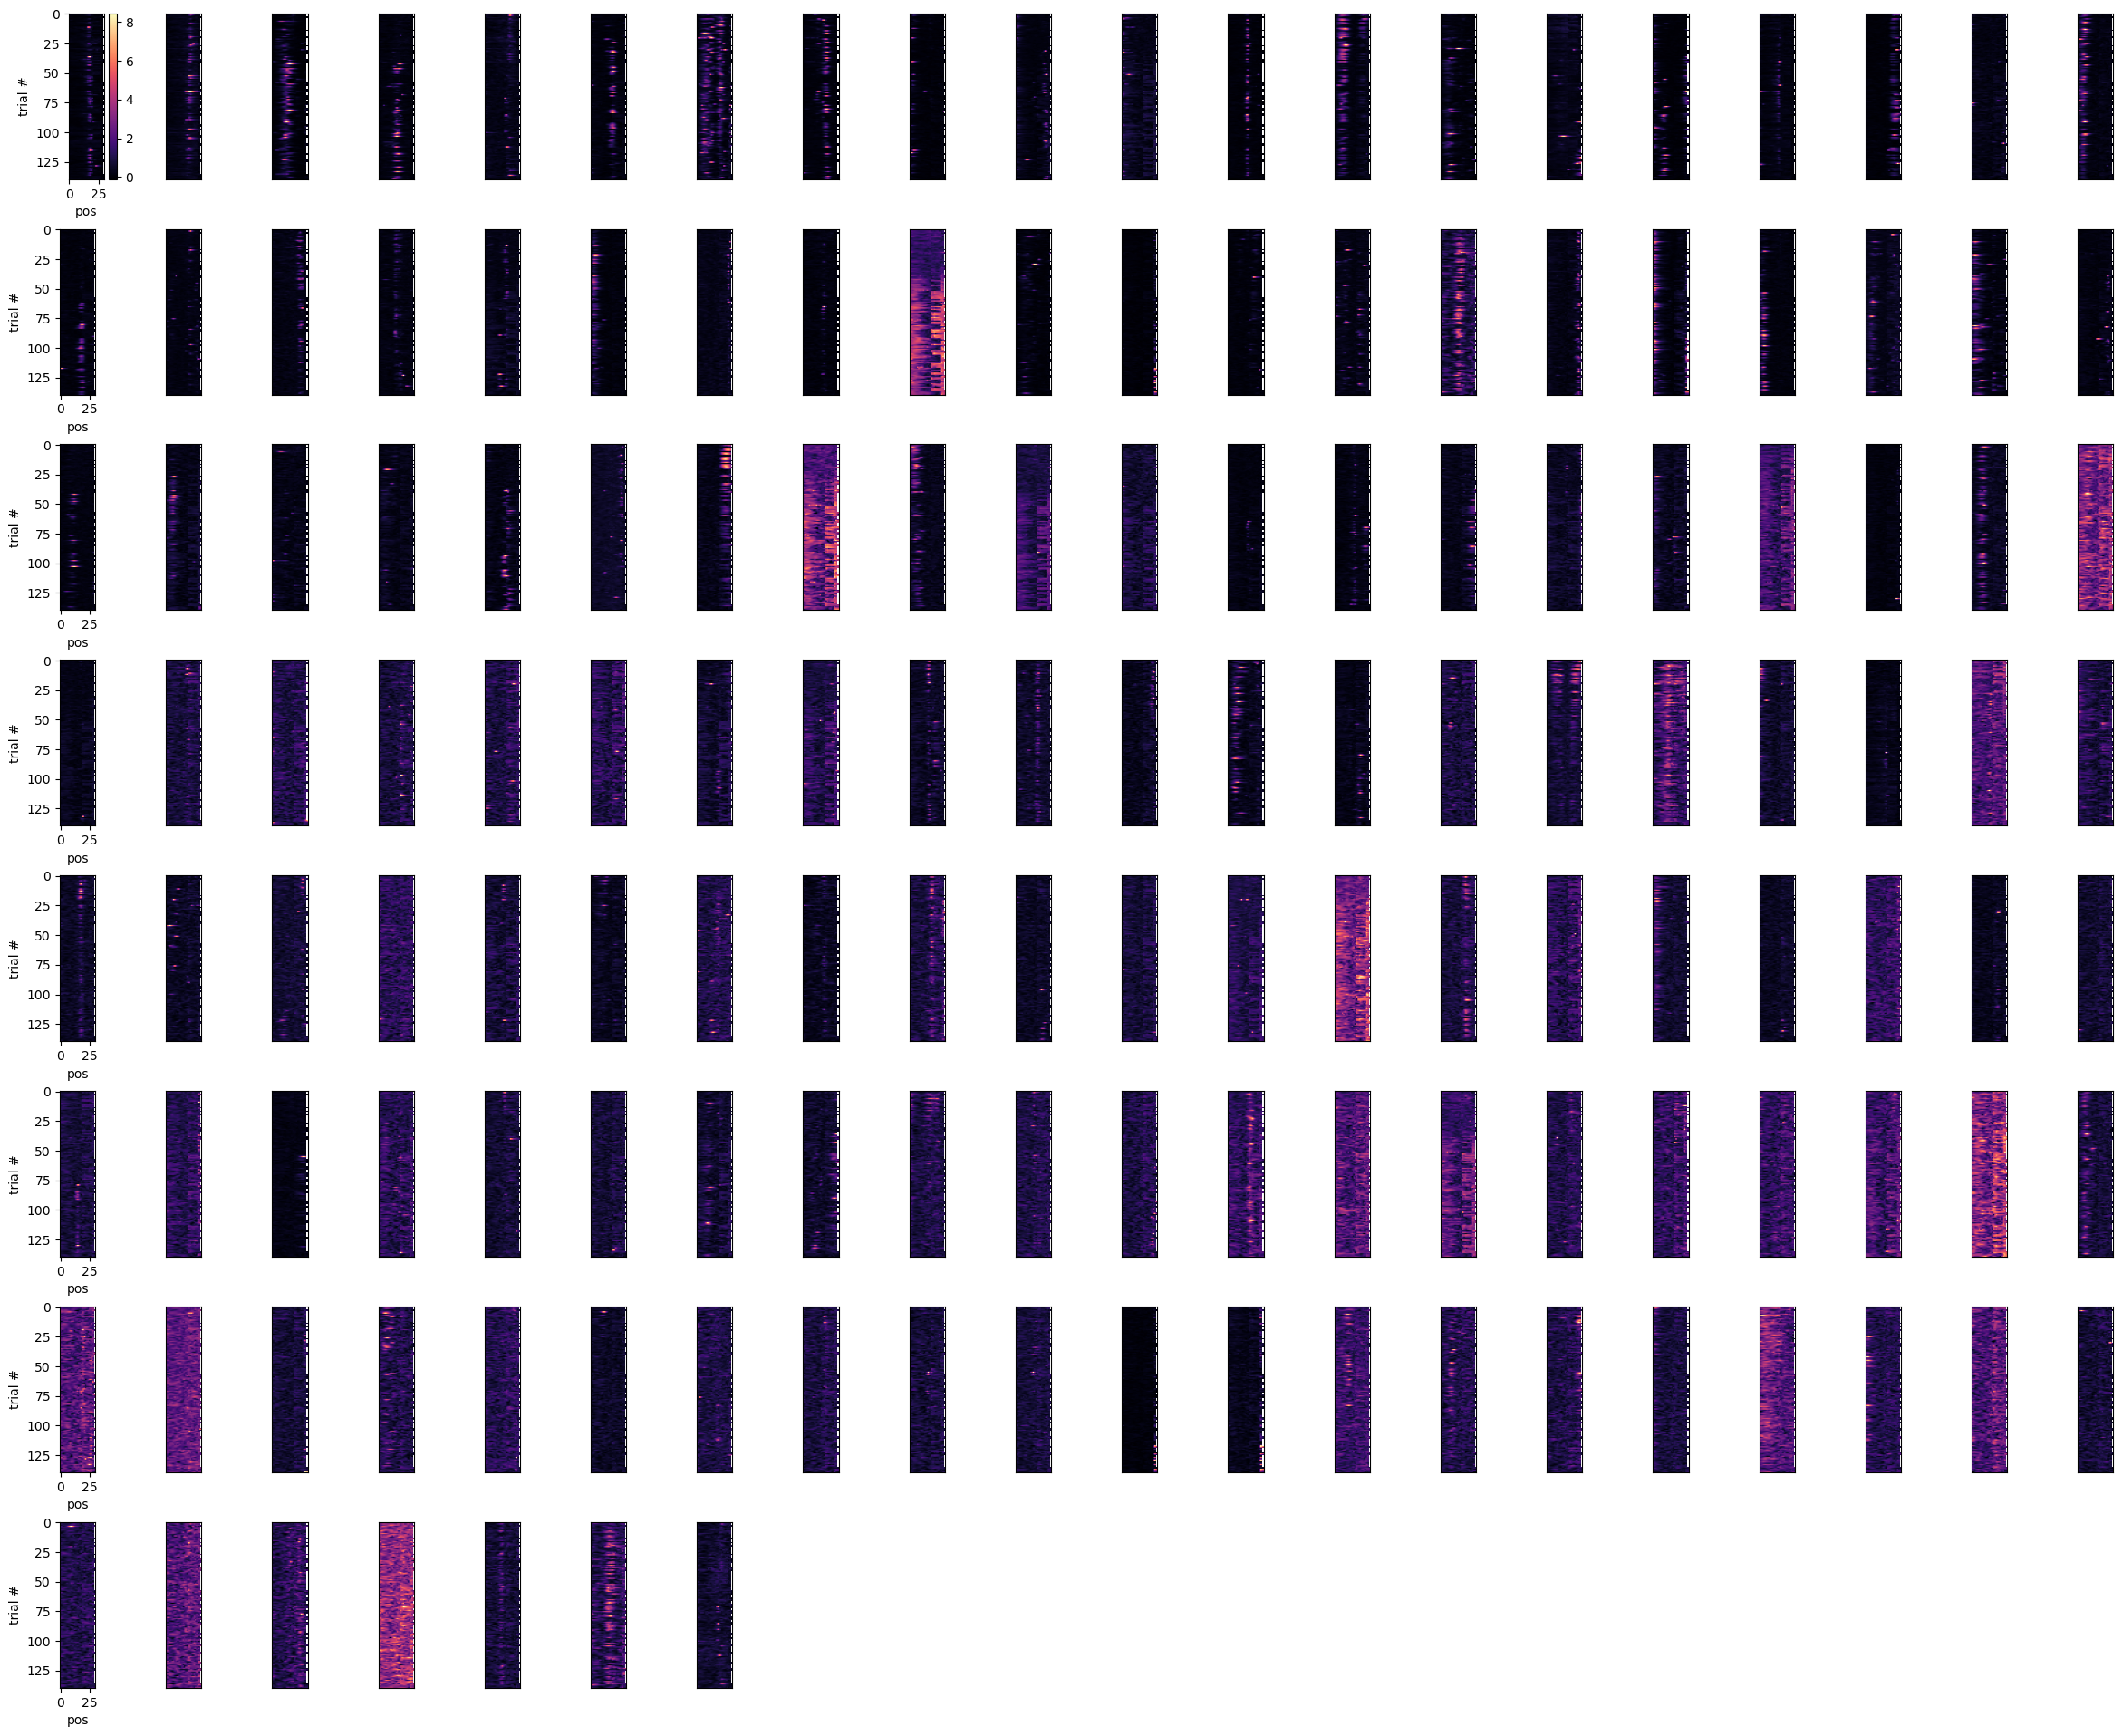

In [124]:
## uncomment to plot only novel trials
# trial_mask = (sess.trial_info['LR']==sess.novel_arm)
tmat = sess.trial_matrices['channel_0_F_dff']
n_cells = tmat.shape[-1]

# plot only place cells using place cell mask
pc_idx = np.where(chan0_mask[:n_cells])[0]
fig = plot_cells(tmat, cell_inds=pc_idx)

# # uncomment to plot all cells
# fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

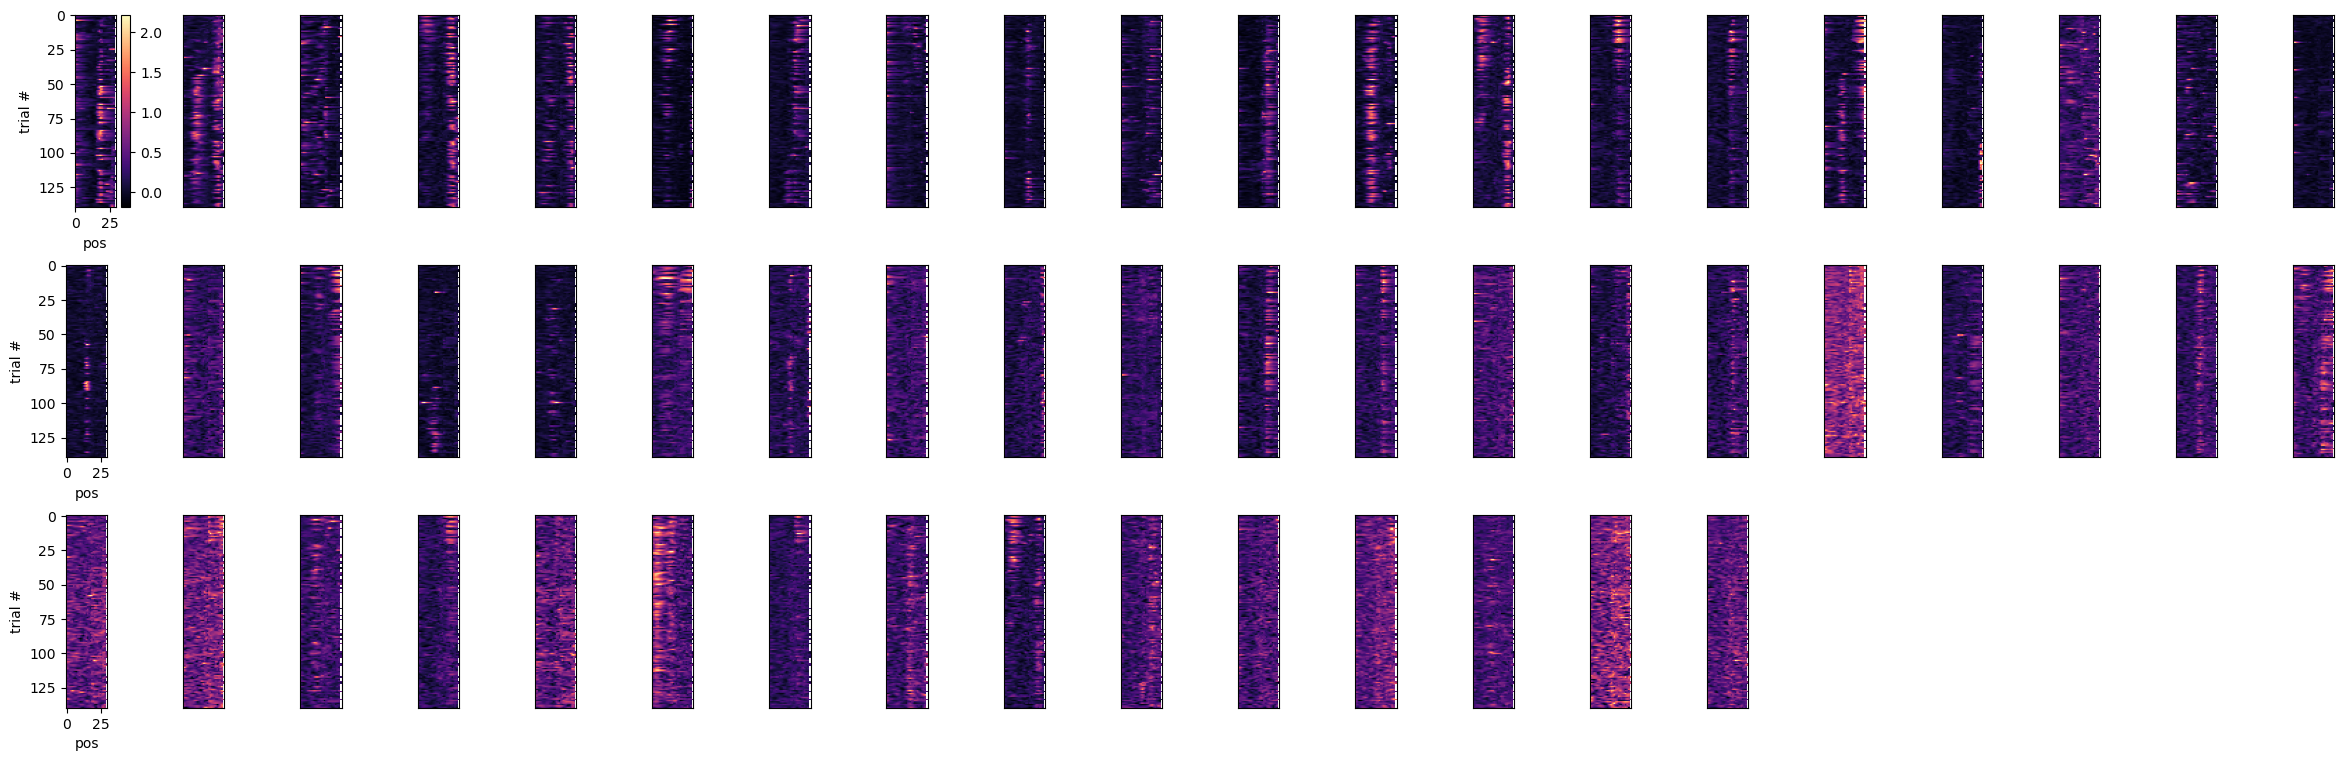

In [125]:
# trial_mask = (sess.trial_info['LR']==sess.novel_arm)*((sess.trial_info['block_number']%2)==0)
tmat = sess.trial_matrices['channel_1_F_dff']
n_cells = tmat.shape[-1]


#place cells only
pc_idx = np.where(chan1_mask[:n_cells])[0]
fig = plot_cells(tmat, cell_inds=pc_idx)

# # all cells
# fig = plot_cells(tmat[trial_mask,:,:], cell_inds=np.array([r for r in range(n_cells)]))

In [10]:
# for mouse in sparse_mice:
mouse = "SparseKO_05"
day = sparse_sessions[mouse][3:-1]
for d in day: 
    print(d)
    date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']
    print(scene)
    
    basedir = f'Z://giocomo/esay/Stx3/2pData/{mouse}/{date}/{scene}'

    stem =  os.path.join(basedir, f'{scene}_{session:03}_{scan:03}')

    d.update({'mouse': mouse ,
          'scan_file':stem + '.sbx',
          'scanheader_file': stem + '.mat',
          'vr_filename': os.path.join("Z://giocomo/esay/Stx3/VRData",mouse,date,"%s_%d.sqlite" %(scene,session)),
          'scan_number': scan,
          'prompt_for_keys': False,
          'VR_only': False,
          'scanner': "NLW",
          'n_channels':2,
             })
    
    sess = stx.session.YMazeSession(**d)
    sess.load_scan_info(sbx_version=3)
    sess.align_VR_to_2P()
    sess.load_suite2p_data(which_ts=('F', 'Fneu'), mux = True)
    sess.get_trial_info()

    align_mux(sess)
    
    chan0_nanmask = np.arange(sess.timeseries['channel_0_F'].shape[1]) % 2 ==0
    chan1_nanmask = np.arange(sess.timeseries['channel_1_F'].shape[1]) % 2 ==1

    sess.neuropil_corrected_dff_ES(Fkey = 'channel_0_F', 
                            Fneukey='channel_0_Fneu', 
                            tau=sess.s2p_ops['channel_0']['tau'],
                               chan_mask = chan0_nanmask,
                            spks_key='channel_0_spks')
    sess.neuropil_corrected_dff_ES(Fkey = 'channel_1_F', 
                            Fneukey='channel_1_Fneu', 
                            tau=sess.s2p_ops['channel_1']['tau'],
                               chan_mask = chan1_nanmask,
                            spks_key='channel_1_spks')


    # add lick and speed from vr_data
    sess.add_timeseries(licks=sess.vr_data['lick']._values)
    sess.add_pos_binned_trial_matrix('licks')
    speed = sess.vr_data['dz']._values * sess.scan_info['frame_rate']
    sess.add_timeseries(speed=speed)
    sess.add_pos_binned_trial_matrix('speed')

    # calculate spks and add speed filter (necessary?)
    spks = np.copy(sess.timeseries['channel_0_F_dff'])
    spks[:, speed < 2] = np.nan
    sess.add_timeseries(channel_0_F_dff_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_0_F_dff_speed_filt')
    spks = np.copy(sess.timeseries['channel_1_F_dff'])
    spks[:, speed < 2] = np.nan
    sess.add_timeseries(channel_1_F_dff_speed_filt=spks)
    sess.add_pos_binned_trial_matrix('channel_1_F_dff_speed_filt')

    # calculate place cells 
    sess.place_cells_calc(Fkey='channel_0_F_dff', out_key='channel_0_F_dff', nperms=100)
    sess.place_cells_calc(Fkey='channel_1_F_dff', out_key='channel_1_F_dff', nperms=100)

    # create mask for place cells only (use for plotting)
    # chan1_mask, chan0_mask = place_cell_only_mask(sess)

    # add nan values back into trials
    reverse_mux_alignment(sess, df_key = 'channel_0_F_dff')
    reverse_mux_alignment(sess, df_key = 'channel_1_F_dff')


    tpu.sess.save_session(sess, 'C:/Users/esay/data/Stx3/YMazeSessPkls/')

{'date': '19_11_2024', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 16, 'novel_arm': -1, 'exp_day': 4}
YMaze_LNovel
Fixing teleports
frame rate 31.25
(124632,) ttl times,(53932,) ca2+ frame times
last time: VR 1725.85375, ca2+ 1725.7920000000001
frame rate 31.25
(124632,) ttl times,(53932,) ca2+ frame times
last time: VR 1725.85375, ca2+ 1725.7920000000001
(26966, 17) (26966, 17)
['Z://giocomo/esay/Stx3/2pData/SparseKO_05/19_11_2024/YMaze_LNovel\\YMaze_LNovel_002_016\\suite2p', 'Z://giocomo/esay/Stx3/2pData/SparseKO_05/19_11_2024/YMaze_LNovel\\YMaze_LNovel_002_016\\chan2/suite2p']


UnpicklingError: invalid load key, '\x00'.

In [29]:
tpu.sess.save_session(sess, 'C:/Users/esay/data/Stx3/YMazeSessPkls/')